In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

BASE_DIR = "/content/gdrive/My Drive/CS282/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00


In [ ]:
!gdown 1E_htEdSsltrC_OX7RY62vLkIa8eAoX5b

Downloading...
From: https://drive.google.com/uc?id=1E_htEdSsltrC_OX7RY62vLkIa8eAoX5b
To: /content/processed.zip
100% 7.03M/7.03M [00:00<00:00, 18.6MB/s]


In [ ]:
!unzip -q -o processed.zip

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision import transforms
from PIL import Image

import os
import copy
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
USE_GPU = False
EPOCHS = 150

In [ ]:
# Config device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class BananaLeafDiseaseDataset(Dataset):
    def __init__(self, target_dir: str, transform=None):
        self.transform = transform

        # Load image paths
        self.image_paths = list(Path(target_dir).glob('*/*.jpg'))
        self.classes, self.class_to_idx = self.load_classes(target_dir)

    def load_image(self, idx: int):
        return Image.open(self.image_paths[idx])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = self.load_image(idx)
        class_name = self.image_paths[idx].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


    def load_classes(self, target_dir):
        """
            Returns:
                classes[]
                class_to_idx{}
        """
        classes = sorted(entry.name for entry in os.scandir(target_dir) if entry.is_dir())
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [ ]:
def train_one_epoch(train_loader, model, criterion, optimizer, scheduler):
    # Train mode
    model.train()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Loop over minibatches
    for inputs, labels in train_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()

        # Update parameters
        optimizer.step()

        # Zero gradients
        optimizer.zero_grad()

        # Track loss
        loss_epoch += loss.detach().item()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    # Update learning rate
    scheduler.step()

    return loss_epoch/len(train_loader), accuracy_epoch.item()/len(train_loader)

In [ ]:
def evaluate_one_epoch(test_loader, model, criterion):
    # Eval mode
    model.eval()

    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0

    # Don't update weights
    with torch.no_grad():
        # Loop over minibatches
        for inputs, labels in test_loader:
            # Send to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss
            loss_epoch += loss.detach().item()

            # Accuracy
            _, preds = torch.max(outputs, 1)
            accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]

    return loss_epoch/len(test_loader), accuracy_epoch.item()/len(test_loader)

In [ ]:
# Plot history
def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True, best_weight_file_name='model.h5'):
    # Initialise outputs
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    max_test_acc = 0.0
    best_model_weights = copy.deepcopy(model.state_dict())

    # Loop over epochs
    for epoch in range(EPOCHS):
        # Train
        train_loss, train_accuracy = train_one_epoch(train_loader, model, criterion, optimizer, scheduler)

        # Evaluate
        test_loss, test_accuracy = evaluate_one_epoch(test_loader, model, criterion)

        # Track metrics
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)
        train_acc_hist.append(train_accuracy)
        test_acc_hist.append(test_accuracy)

        # Print loss
        if verbose:
            if (epoch+1)%1==0:
                print(f'Epoch {epoch+1}/{EPOCHS}, loss {train_loss:.5f}, test_loss {test_loss:.5f}, accuracy {train_accuracy:.5f}, test_accuracy {test_accuracy:.5f}')

        # Save best weight
        if test_accuracy > max_test_acc:
          max_test_acc = test_accuracy
          best_model_weights = copy.deepcopy(model.state_dict())

    # Save best weight to file
    torch.save(best_model_weights, BASE_DIR + best_weight_file_name)

    return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

In [ ]:
basic_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_transforms = transforms.Compose([
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [ ]:
train_dataset = BananaLeafDiseaseDataset('./processed/train', transform=train_transforms)
test_dataset = BananaLeafDiseaseDataset('./processed/test', transform=basic_transforms)

In [ ]:
# Address class imbalance
classes = sorted(entry.name for entry in os.scandir('./processed/train') if entry.is_dir())
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

def get_weights(images):
    num_images = len(images)
    count_per_class = [0] * len(classes)

    for img in images:
        img_class = img.parent.name
        class_idx = class_to_idx[img_class]
        count_per_class[class_idx] += 1

    weight_per_class = [0.0] * len(classes)

    for i in range(len(classes)):
        weight_per_class[i] = float(num_images) / float(count_per_class[i])

    weights = [0] * num_images

    for i, img in enumerate(images):
        img_class = img.parent.name
        class_idx = class_to_idx[img_class]
        weights[i] = weight_per_class[class_idx]

    return weights

In [ ]:
weights = get_weights(train_dataset.image_paths)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=20, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)

In [ ]:
model = torchvision.models.resnet50()
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=3
    ),
    torch.nn.Sigmoid()
)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer, base_lr=1e-6, max_lr=1e-4, cycle_momentum=False
        )

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0


In [ ]:
train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader)

Epoch 1/150, loss 1.09746, test_loss 1.08326, accuracy 0.31776, test_accuracy 0.34000
Epoch 2/150, loss 1.07971, test_loss 1.06080, accuracy 0.37289, test_accuracy 0.40000
Epoch 3/150, loss 1.07049, test_loss 1.05392, accuracy 0.46215, test_accuracy 0.47000
Epoch 4/150, loss 1.05658, test_loss 1.04521, accuracy 0.49377, test_accuracy 0.54000
Epoch 5/150, loss 1.04590, test_loss 1.04145, accuracy 0.50618, test_accuracy 0.51000
Epoch 6/150, loss 1.03665, test_loss 1.01801, accuracy 0.51211, test_accuracy 0.53000
Epoch 7/150, loss 1.03739, test_loss 1.01294, accuracy 0.50553, test_accuracy 0.57000
Epoch 8/150, loss 1.03149, test_loss 1.01539, accuracy 0.51368, test_accuracy 0.54000
Epoch 9/150, loss 1.02052, test_loss 1.00585, accuracy 0.53443, test_accuracy 0.58000
Epoch 10/150, loss 1.01725, test_loss 1.00723, accuracy 0.54465, test_accuracy 0.55000
Epoch 11/150, loss 1.01904, test_loss 1.00226, accuracy 0.53456, test_accuracy 0.53000
Epoch 12/150, loss 1.02036, test_loss 1.00986, accur

In [ ]:
torch.save(model.state_dict(), 'resnet.h5')

In [ ]:
# Define MLP Mixer

In [ ]:
from torch import nn
from einops.layers.torch import Rearrange

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class MixerBlock(nn.Module):
    def __init__(self, dim, num_patch, token_dim, channel_dim, dropout = 0.):
        super().__init__()

        self.token_mix = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('b n d -> b d n'),
            FeedForward(num_patch, token_dim, dropout),
            Rearrange('b d n -> b n d')
        )

        self.channel_mix = nn.Sequential(
            nn.LayerNorm(dim),
            FeedForward(dim, channel_dim, dropout),
        )

    def forward(self, x):
        x = x + self.token_mix(x)
        x = x + self.channel_mix(x)
        return x

class MLPMixer(nn.Module):
    def __init__(
        self,
        in_channels,
        dim,
        num_classes,
        patch_size,
        image_size,
        depth,
        token_dim,
        channel_dim
    ):
        super().__init__()

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.num_patch =  (image_size// patch_size) ** 2
        self.to_patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, dim, patch_size, patch_size),
            Rearrange('b c h w -> b (h w) c'),
        )

        self.mixer_blocks = nn.ModuleList([])

        for _ in range(depth):
            self.mixer_blocks.append(MixerBlock(dim, self.num_patch, token_dim, channel_dim))

        self.layer_norm = nn.LayerNorm(dim)

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.to_patch_embedding(x)
        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)

        x = self.layer_norm(x)
        x = x.mean(dim=1)
        return self.mlp_head(x)

In [ ]:
model_mixer = MLPMixer(in_channels=3, image_size=224, patch_size=16, num_classes=3,
                     dim=512, depth=12, token_dim=256, channel_dim=2048)
model_mixer.to(device)
optimizer = torch.optim.AdamW(model_mixer.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer, base_lr=1e-6, max_lr=1e-4, cycle_momentum=False
            )

In [ ]:
train_loss_hist_mixer, test_loss_hist_mixer, train_acc_hist_mixer, test_acc_hist_mixer = train_model(model_mixer, criterion, optimizer, scheduler, train_loader, test_loader)

Epoch 1/150, loss 1.05475, test_loss 1.01187, accuracy 0.45228, test_accuracy 0.50000
Epoch 2/150, loss 0.96983, test_loss 0.94141, accuracy 0.59816, test_accuracy 0.58000
Epoch 3/150, loss 0.93117, test_loss 0.89046, accuracy 0.58368, test_accuracy 0.63000
Epoch 4/150, loss 0.88537, test_loss 0.87485, accuracy 0.63798, test_accuracy 0.68000
Epoch 5/150, loss 0.87912, test_loss 0.86208, accuracy 0.63224, test_accuracy 0.63000
Epoch 6/150, loss 0.87642, test_loss 0.86569, accuracy 0.62228, test_accuracy 0.65000
Epoch 7/150, loss 0.86321, test_loss 0.89678, accuracy 0.63890, test_accuracy 0.60000
Epoch 8/150, loss 0.83914, test_loss 0.87071, accuracy 0.64640, test_accuracy 0.67000
Epoch 9/150, loss 0.83672, test_loss 0.86247, accuracy 0.64303, test_accuracy 0.64000
Epoch 10/150, loss 0.82091, test_loss 0.87328, accuracy 0.67724, test_accuracy 0.64000
Epoch 11/150, loss 0.82607, test_loss 0.81730, accuracy 0.67057, test_accuracy 0.68000
Epoch 12/150, loss 0.80398, test_loss 0.86159, accur

In [ ]:
torch.save(model_mixer.state_dict(), BASE_DIR + 'Mixer-S.h5')

In [ ]:
model_mixer_2 = MLPMixer(in_channels=3, image_size=224, patch_size=16, num_classes=3,
                     dim=512, depth=8, token_dim=256, channel_dim=1024)
model_mixer_2.to(device)
optimizer = torch.optim.AdamW(model_mixer_2.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer, base_lr=1e-6, max_lr=1e-4, cycle_momentum=False
            )

In [ ]:
train_loss_hist_mixer_2, test_loss_hist_mixer_2, train_acc_hist_mixer_2, test_acc_hist_mixer_2 = train_model(model_mixer_2, criterion, optimizer, scheduler, train_loader, test_loader)

Epoch 1/150, loss 1.11812, test_loss 1.06697, accuracy 0.31759, test_accuracy 0.48000
Epoch 2/150, loss 1.04904, test_loss 1.01247, accuracy 0.45202, test_accuracy 0.49000
Epoch 3/150, loss 1.00278, test_loss 0.95891, accuracy 0.53886, test_accuracy 0.58000
Epoch 4/150, loss 0.97786, test_loss 0.94875, accuracy 0.55719, test_accuracy 0.59000
Epoch 5/150, loss 0.95095, test_loss 0.91719, accuracy 0.57053, test_accuracy 0.64000
Epoch 6/150, loss 0.90986, test_loss 0.92849, accuracy 0.64386, test_accuracy 0.62000
Epoch 7/150, loss 0.86408, test_loss 0.87620, accuracy 0.67228, test_accuracy 0.66000
Epoch 8/150, loss 0.89397, test_loss 0.86905, accuracy 0.62219, test_accuracy 0.65000
Epoch 9/150, loss 0.88254, test_loss 0.86106, accuracy 0.63136, test_accuracy 0.63000
Epoch 10/150, loss 0.85677, test_loss 0.89821, accuracy 0.66149, test_accuracy 0.64000
Epoch 11/150, loss 0.83868, test_loss 0.86436, accuracy 0.65140, test_accuracy 0.69000
Epoch 12/150, loss 0.85440, test_loss 0.83730, accur

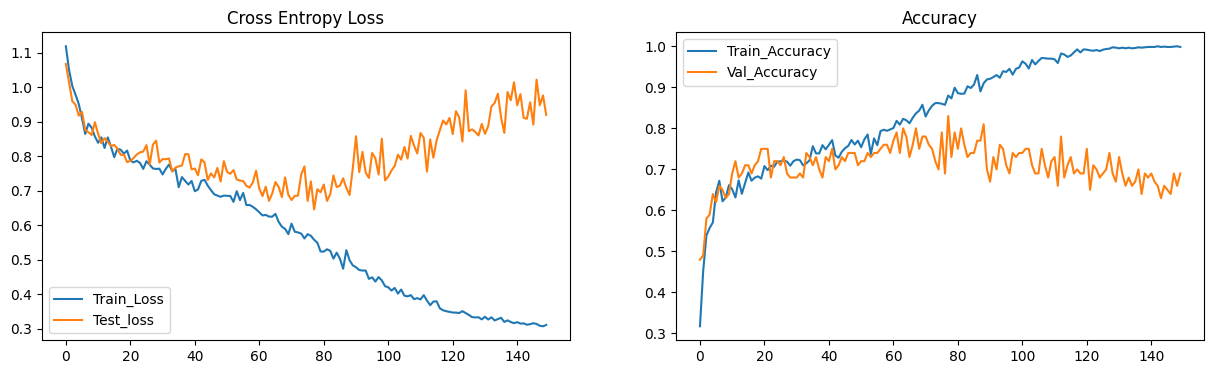

In [ ]:
plot_hist(train_loss_hist_mixer_2, test_loss_hist_mixer_2, train_acc_hist_mixer_2, test_acc_hist_mixer_2)

In [ ]:
torch.save(model_mixer_2.state_dict(), BASE_DIR + 'Mixer-XS.h5')

In [ ]:
model_mixer_3 = MLPMixer(in_channels=3, image_size=224, patch_size=16, num_classes=3,
                     dim=256, depth=4, token_dim=128, channel_dim=1024)
model_mixer_3.to(device)
optimizer = torch.optim.AdamW(model_mixer_3.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer, base_lr=1e-6, max_lr=1e-4, cycle_momentum=False
            )

In [ ]:
train_loss_hist_mixer_3, test_loss_hist_mixer_3, train_acc_hist_mixer_3, test_acc_hist_mixer_3 = train_model(model_mixer_3, criterion, optimizer, scheduler, train_loader, test_loader)

Epoch 1/150, loss 1.09117, test_loss 1.06650, accuracy 0.34364, test_accuracy 0.39000
Epoch 2/150, loss 1.03821, test_loss 1.02764, accuracy 0.53386, test_accuracy 0.51000
Epoch 3/150, loss 1.01326, test_loss 0.99992, accuracy 0.54465, test_accuracy 0.49000
Epoch 4/150, loss 0.99375, test_loss 0.97839, accuracy 0.55544, test_accuracy 0.54000
Epoch 5/150, loss 0.95950, test_loss 0.94270, accuracy 0.59219, test_accuracy 0.55000
Epoch 6/150, loss 0.95092, test_loss 0.95152, accuracy 0.55132, test_accuracy 0.58000
Epoch 7/150, loss 0.92720, test_loss 0.92795, accuracy 0.59794, test_accuracy 0.63000
Epoch 8/150, loss 0.92460, test_loss 0.92452, accuracy 0.59789, test_accuracy 0.59000
Epoch 9/150, loss 0.91291, test_loss 0.91284, accuracy 0.60289, test_accuracy 0.59000
Epoch 10/150, loss 0.91291, test_loss 0.90091, accuracy 0.59145, test_accuracy 0.62000
Epoch 11/150, loss 0.88774, test_loss 0.91323, accuracy 0.60224, test_accuracy 0.59000
Epoch 12/150, loss 0.89332, test_loss 0.87375, accur

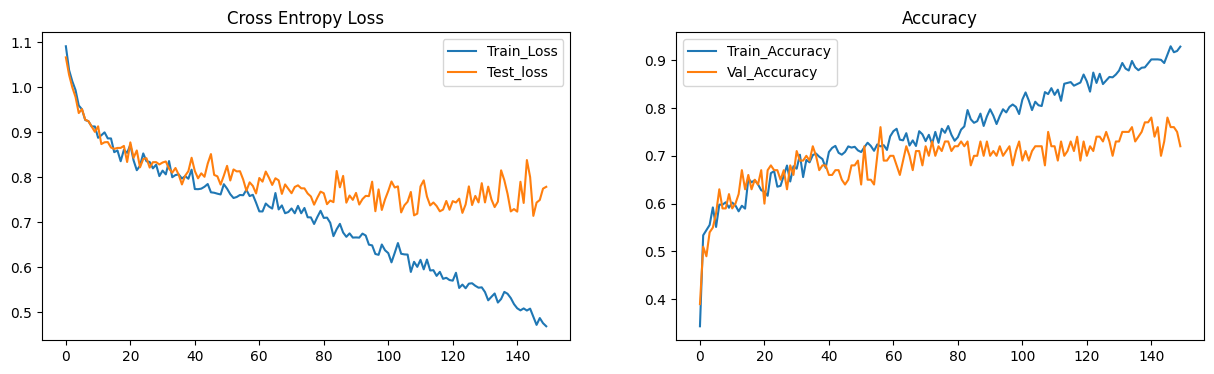

In [ ]:
plot_hist(train_loss_hist_mixer_3, test_loss_hist_mixer_3, train_acc_hist_mixer_3, test_acc_hist_mixer_3)

In [ ]:
torch.save(model_mixer_3.state_dict(), BASE_DIR + 'Mixer-XXS.h5')

In [ ]:
model_mixer_4 = MLPMixer(in_channels=3, image_size=224, patch_size=16, num_classes=3,
                     dim=256, depth=4, token_dim=128, channel_dim=512)
model_mixer_4.to(device)
optimizer = torch.optim.AdamW(model_mixer_4.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer, base_lr=1e-6, max_lr=1e-4, cycle_momentum=False
            )

In [ ]:
train_loss_hist_mixer_4, test_loss_hist_mixer_4, train_acc_hist_mixer_4, test_acc_hist_mixer_4 = train_model(model_mixer_4, criterion, optimizer, scheduler, train_loader, test_loader)

Epoch 1/150, loss 1.05206, test_loss 1.04540, accuracy 0.45114, test_accuracy 0.48000
Epoch 2/150, loss 1.03236, test_loss 1.02528, accuracy 0.46382, test_accuracy 0.48000
Epoch 3/150, loss 1.01385, test_loss 0.99799, accuracy 0.53632, test_accuracy 0.56000
Epoch 4/150, loss 0.98581, test_loss 0.98429, accuracy 0.58544, test_accuracy 0.54000
Epoch 5/150, loss 0.98008, test_loss 0.97081, accuracy 0.59566, test_accuracy 0.57000
Epoch 6/150, loss 0.97514, test_loss 0.95834, accuracy 0.55228, test_accuracy 0.53000
Epoch 7/150, loss 0.95274, test_loss 0.95199, accuracy 0.58732, test_accuracy 0.55000
Epoch 8/150, loss 0.93825, test_loss 0.94322, accuracy 0.60136, test_accuracy 0.56000
Epoch 9/150, loss 0.92624, test_loss 0.94856, accuracy 0.63469, test_accuracy 0.61000
Epoch 10/150, loss 0.92614, test_loss 0.91581, accuracy 0.60719, test_accuracy 0.62000
Epoch 11/150, loss 0.92203, test_loss 0.90291, accuracy 0.60053, test_accuracy 0.63000
Epoch 12/150, loss 0.91157, test_loss 0.91379, accur

In [ ]:
torch.save(model_mixer_4.state_dict(), BASE_DIR + 'Mixer-tiny.h5')